In [320]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
import requests
import pymc3 as pm
from pymc3 import forestplot
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
from pymc3 import forestplot, traceplot, plot_posterior, summary

import pandas as pd
import numpy as np
import theano
import theano.tensor as tt
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [321]:
SCRIPT_PATH='.'
module_path = os.path.abspath(os.path.join(SCRIPT_PATH))
if module_path not in sys.path:
    sys.path.append(module_path)

In [322]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [323]:
from utils import load_county_case_data, load_patient_data, get_delay_onset_confirmation_probabilities
from utils import prepare_county_cases, adjust_onset_for_right_censorship, confirmed_to_onset
from utils import create_and_run_model_for_counties, df_from_model, reparametrize
from utils import agg_cases_to_state_level, aggregate_results, plot_rt, prepare_cases, load_daily_state_cases, load_county_case_data
from utils import compute_mean_kinsa_atypical_illness, compute_delay_onset_confirmation_probabilities, compute_adjusted_cases
from utils import read_google_mobility_data

In [324]:
mobility = read_google_mobility_data()
mobility.dropna(inplace=True)
mobility.head()

,state_name,county,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,state,countyFIPS
255,Alabama,Baldwin County,2020-02-15,17.0,12.0,55.0,8.0,6.0,-2.0,AL,1003.0
256,Alabama,Baldwin County,2020-02-16,8.0,8.0,-12.0,7.0,-3.0,2.0,AL,1003.0
257,Alabama,Baldwin County,2020-02-17,9.0,9.0,31.0,7.0,-3.0,1.0,AL,1003.0
258,Alabama,Baldwin County,2020-02-18,7.0,8.0,21.0,0.0,2.0,0.0,AL,1003.0
259,Alabama,Baldwin County,2020-02-19,12.0,9.0,41.0,8.0,3.0,-1.0,AL,1003.0


In [325]:
mobility.dtypes

state_name                                                    object
county                                                        object
date                                                  datetime64[ns]
retail_and_recreation_percent_change_from_baseline           float64
grocery_and_pharmacy_percent_change_from_baseline            float64
parks_percent_change_from_baseline                           float64
transit_stations_percent_change_from_baseline                float64
workplaces_percent_change_from_baseline                      float64
residential_percent_change_from_baseline                     float64
state                                                         object
countyFIPS                                                   float64
dtype: object

In [326]:
kinsa = pd.read_csv("data/kinsa.csv")
kinsa.drop(["Unnamed: 0", "region_type", "observed_ili"], axis=1, inplace=True)
kinsa.dropna(inplace=True)

In [327]:
kinsa.head()

,region_id,region_name,state,date,doy,atypical_ili,atypical_ili_delta,anomaly_fevers,forecast_expected,forecast_lower,forecast_upper
1288,1021,Chilton County,AL,2020-03-06,66,3.953519,0.020049,4.910440,2.882840,1.832210,3.933470
1292,1097,Mobile County,AL,2020-03-06,66,5.020032,0.000890,1.802003,3.993658,2.968173,5.019142
1345,1043,Cullman County,AL,2020-03-07,67,4.567976,0.247477,67.605764,3.217172,2.113845,4.320499
1362,1117,Shelby County,AL,2020-03-07,67,4.252232,0.124317,356.004828,3.015529,1.903143,4.127914
1375,1103,Morgan County,AL,2020-03-07,67,4.482549,0.043693,64.825846,3.316540,2.194224,4.438856


In [328]:
kinsa.dtypes

region_id               int64
region_name            object
state                  object
date                   object
doy                     int64
atypical_ili          float64
atypical_ili_delta    float64
anomaly_fevers        float64
forecast_expected     float64
forecast_lower        float64
forecast_upper        float64
dtype: object

In [329]:
kinsa.rename(columns={"region_name": "county"}, inplace=True)

In [330]:
kinsa.date = pd.to_datetime(kinsa.date, format="%Y-%m-%d")

In [331]:
cases = load_county_case_data()
cases.date = pd.to_datetime(cases.date, format="%Y-%m-%d")

In [332]:
cases.head()

,countyFIPS,county,state,stateFIPS,date,cases
0,0,Statewide Unallocated,AL,1,2020-01-22,0.0
1,1001,Autauga County,AL,1,2020-01-22,0.0
2,1003,Baldwin County,AL,1,2020-01-22,0.0
3,1005,Barbour County,AL,1,2020-01-22,0.0
4,1007,Bibb County,AL,1,2020-01-22,0.0


In [333]:
data = cases.merge(kinsa, on=["state", "county", "date"], how="inner")
data = data.merge(mobility, on=["state", "county", "date"], how="inner")
data.drop(["countyFIPS_x", "countyFIPS_y"], axis=1, inplace=True)

In [334]:
data.head()

,county,state,stateFIPS,date,cases,region_id,doy,atypical_ili,atypical_ili_delta,anomaly_fevers,forecast_expected,forecast_lower,forecast_upper,state_name,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Benton County,AR,5,2020-03-02,0.0,5007,62,8.594951,1.220511,2914.543410,6.345887,5.317334,7.374440,Arkansas,8.0,4.0,38.0,-2.0,4.0,0.0
1,Pulaski County,AR,5,2020-03-02,0.0,5119,62,9.025069,0.701219,2886.594012,7.178338,6.032826,8.323850,Arkansas,14.0,9.0,19.0,-4.0,3.0,-1.0
2,Sebastian County,AR,5,2020-03-02,0.0,5131,62,7.951307,0.826540,677.382307,6.087519,5.050270,7.124768,Arkansas,15.0,13.0,52.0,2.0,1.0,-1.0
3,Washington County,AR,5,2020-03-02,0.0,5143,62,8.486538,1.257356,1782.566001,6.234446,5.239711,7.229182,Arkansas,10.0,8.0,55.0,-4.0,2.0,0.0
4,Polk County,IA,19,2020-03-02,0.0,19153,62,7.440229,0.302904,1605.015108,6.268704,5.400085,7.137324,Iowa,5.0,22.0,17.0,-4.0,4.0,-1.0


# Complete pooling: treat all IL counties the same and estimate a single predicted new cases output variable

In [335]:
state = "IL"
state_data = data[data.state == state]

In [336]:
state_data.county.unique()

array(['Cook County', 'Lake County', 'DuPage County', 'Kane County',
       'McHenry County', 'Will County', 'Champaign County',
       'LaSalle County', 'Madison County', 'St. Clair County',
       'McLean County', 'Peoria County', 'Rock Island County',
       'Sangamon County', 'Winnebago County'], dtype=object)

In [337]:
state_data.head()

,county,state,stateFIPS,date,cases,region_id,doy,atypical_ili,atypical_ili_delta,anomaly_fevers,forecast_expected,forecast_lower,forecast_upper,state_name,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
1661,Cook County,IL,17,2020-03-13,13.0,17031,73,5.500605,0.027745,1416.690005,4.529433,3.586006,5.472860,Illinois,4.0,43.0,16.0,-11.0,-5.0,1.0
1927,Cook County,IL,17,2020-03-14,11.0,17031,74,5.502181,0.137413,7016.481944,4.421341,3.477914,5.364767,Illinois,-8.0,29.0,-9.0,-11.0,-1.0,3.0
1928,Lake County,IL,17,2020-03-14,1.0,17097,74,5.523624,0.055094,477.989479,4.567476,3.666422,5.468530,Illinois,-7.0,44.0,-13.0,-16.0,0.0,3.0
2739,Cook County,IL,17,2020-03-17,30.0,17031,77,5.225619,1.150421,58741.786811,3.131771,2.188345,4.075198,Illinois,-24.0,13.0,36.0,-39.0,-36.0,13.0
2740,DuPage County,IL,17,2020-03-17,21.0,17043,77,4.847058,0.529660,6992.638298,3.386121,2.454843,4.317399,Illinois,-26.0,20.0,38.0,-48.0,-36.0,15.0


In [338]:
transit = state_data["transit_stations_percent_change_from_baseline"].values
transit

array([-11., -11., -16., -39., -48., -28., -36., -49., -18., -37., -48.,
       -54., -38., -44.,   1., -59., -13., -18., -27., -36., -52., -58.,
       -39., -50.,  -2., -60., -16.,  -9., -23., -28., -20., -23., -27.,
       -11., -28., -50., -53., -39., -46.,  10., -52., -17.,  -9., -27.,
       -23., -18., -25., -24., -17., -34., -48., -44., -42., -50.,   0.,
       -51., -14., -14., -27., -26., -21., -29., -24., -22., -59., -62.,
       -56., -49., -62., -16., -68., -36., -28., -52., -50., -35., -49.,
       -31., -35., -46., -64., -68., -49., -57.,  -3., -70., -27., -20.,
       -45., -35., -29., -33., -34., -24., -47., -62., -67., -49., -56.,
       -68., -23., -24., -31., -34., -30., -35., -33., -19., -38., -59.,
       -65., -46., -54., -64., -24., -17., -33., -34., -20., -29., -28.,
       -20., -41., -64., -69., -46., -58., -12., -72., -34., -17., -36.,
       -39., -23., -25., -33., -22., -62., -64., -50., -57.,  -3., -65.,
       -30., -39., -35., -35., -32., -40., -58., -5

In [339]:
state_data.county = state_data.county.map(str.strip)
mn_counties = state_data.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))
county = state_data['county_code'] = state_data.county.replace(county_lookup).values

/Users/gryv9001/miniconda3/envs/dsai37/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/gryv9001/miniconda3/envs/dsai37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [340]:
atypical_ill_values = state_data["atypical_ili"].values
case_values = state_data["cases"].values
log_case_values = state_data["log_cases"] = np.log(case_values+0.1)

/Users/gryv9001/miniconda3/envs/dsai37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Pooled model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1710.44draws/s]


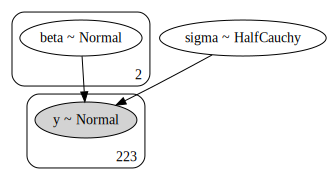

In [341]:
with Model() as pooled_model:

     beta = Normal('beta', 0, sigma=1e5, shape=2)
     sigma = HalfCauchy('sigma', 5)

     theta = beta[0] + beta[1]*atypical_ill_values

     y = Normal('y', theta, sigma=sigma, observed=log_case_values)
     pooled_trace = sample(1000, tune=1000)
model_to_graphviz(pooled_model)

In [342]:
b0, m0 = pooled_trace['beta'].mean(axis=0)

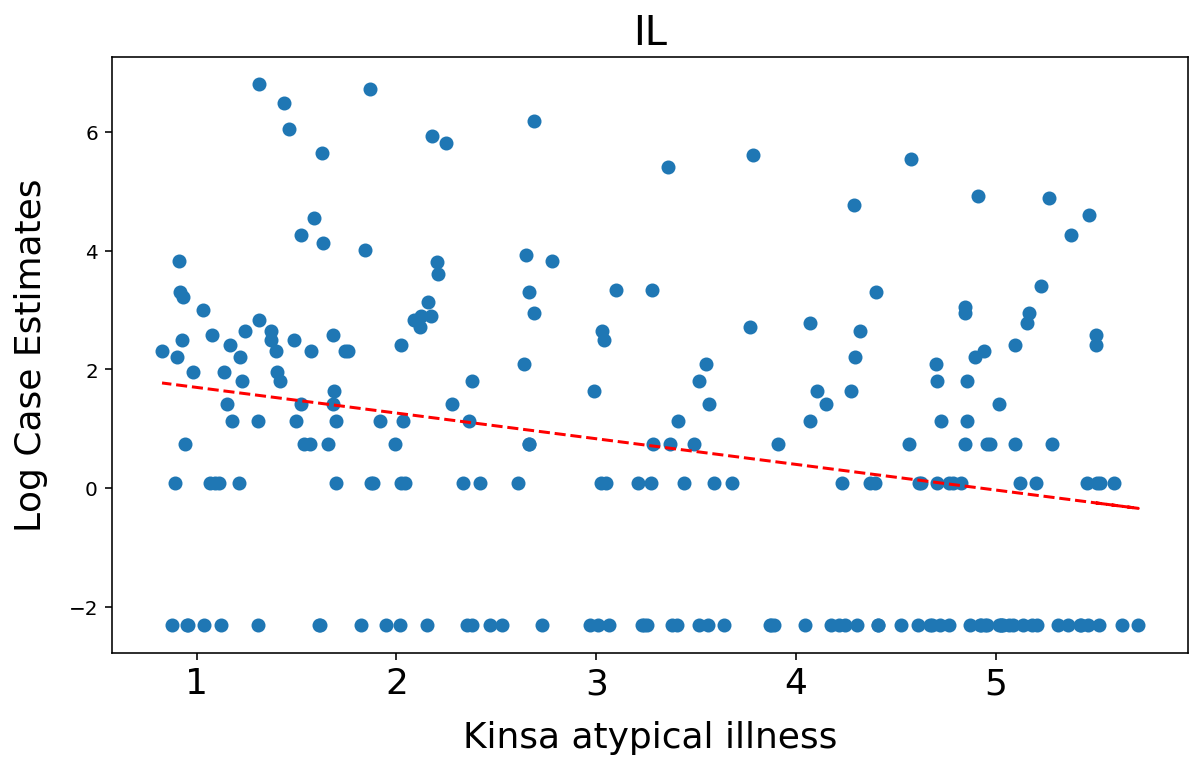

In [343]:
figure, ax1 = plt.subplots(figsize=(9, 6))
plt.scatter(atypical_ill_values, log_case_values)
ax1.plot(atypical_ill_values, m0*atypical_ill_values+b0, 'r--')
ax1.set_xlabel("Kinsa atypical illness", fontsize=18, labelpad=10)
ax1.set_ylabel("Log Case Estimates", fontsize=18, labelpad=10)
ax1.tick_params(axis='x', labelsize= 18)
plt.title(state, fontsize=20)
plt.gcf().subplots_adjust(bottom=0.3)
plt.gcf().subplots_adjust(left=0.3)
figure.tight_layout(pad=3.0);    
plt.savefig("reports/kinsa_" + state + "pooled_model.pdf", bbox_inches="tight")
plt.show()
plt.close()       

## Unpooled model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta1, beta0]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:05<00:00, 1349.19draws/s]
The number of effective samples is smaller than 25% for some parameters.


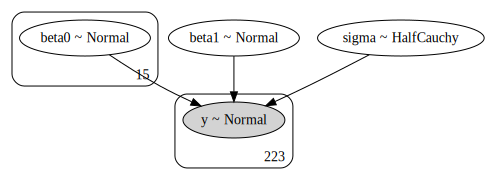

In [344]:
with Model() as unpooled_model:

    beta0 = Normal('beta0', 0, sigma=1e5, shape=counties)
    beta1 = Normal('beta1', 0, sigma=1e5)
    sigma = HalfCauchy('sigma', 5)

    theta = beta0[county] + beta1*atypical_ill_values

    y = Normal('y', theta, sigma=sigma, observed=log_case_values)
    unpooled_trace = sample(1000, tune=1000)
model_to_graphviz(unpooled_model)

<Figure size 432x1008 with 0 Axes>

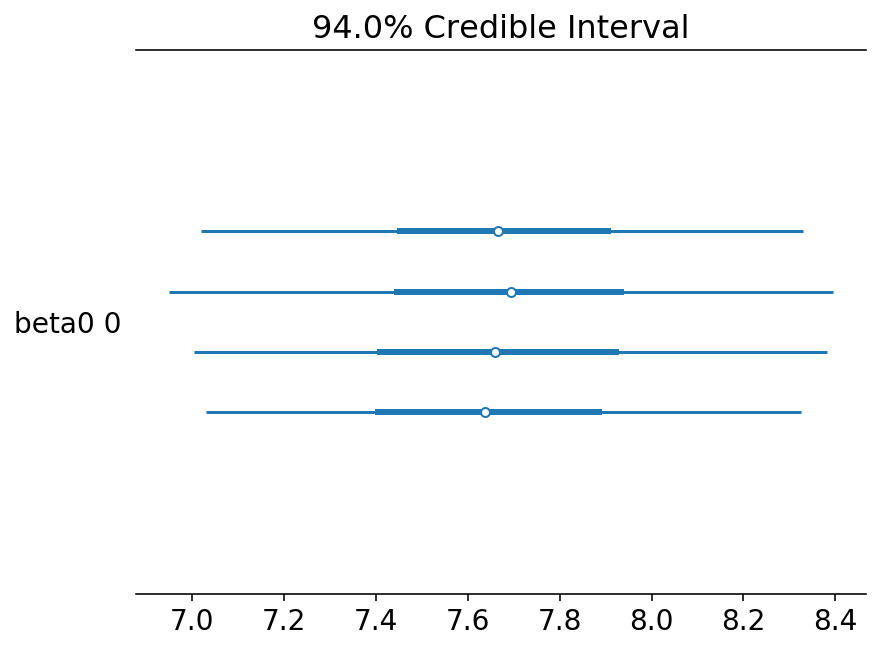

In [345]:
plt.figure(figsize=(6,14))
forestplot(unpooled_trace, var_names=['beta0'])
plt.show()
plt.close()

In [346]:
unpooled_estimates = pd.Series(unpooled_trace['beta0'].mean(axis=0), index=mn_counties)
unpooled_se = pd.Series(unpooled_trace['beta0'].std(axis=0), index=mn_counties)

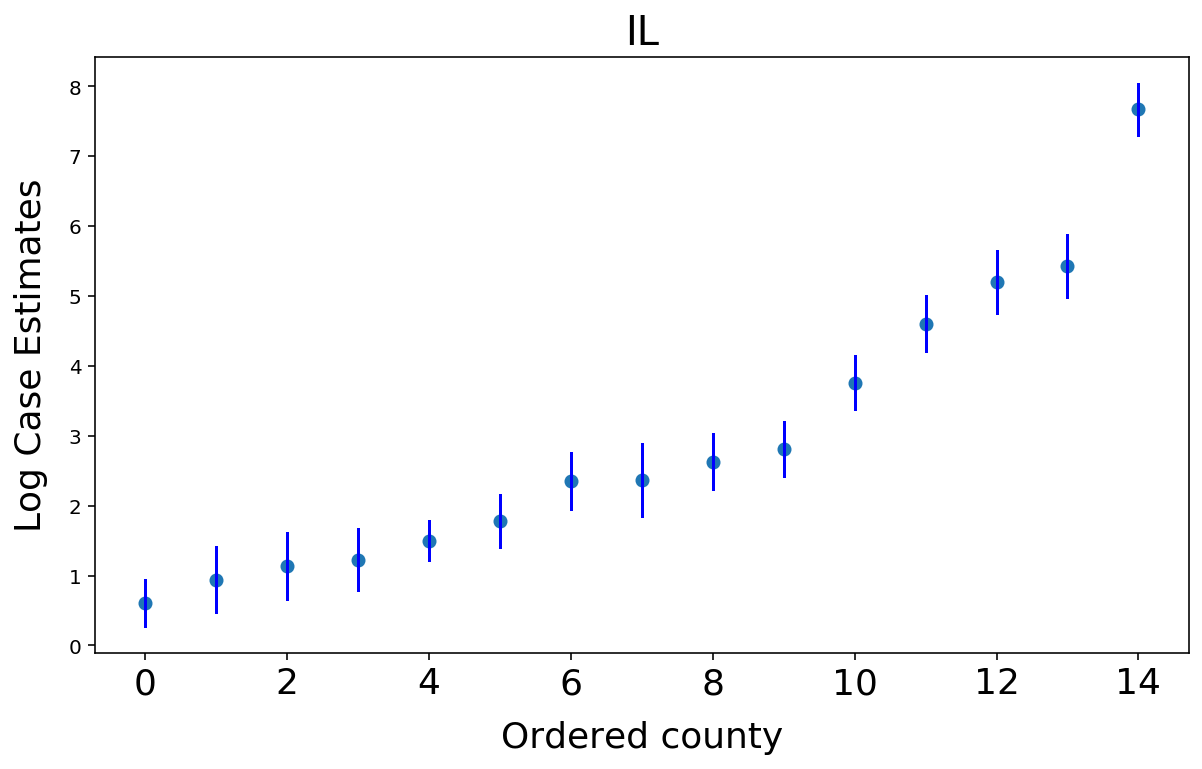

In [347]:
order = unpooled_estimates.sort_values().index

figure, ax1 = plt.subplots(figsize=(9, 6))
plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')

ax1.set_xlabel("Ordered county", fontsize=18, labelpad=10)
ax1.set_ylabel("Log Case Estimates", fontsize=18, labelpad=10)
ax1.tick_params(axis='x', labelsize= 18)
plt.title(state, fontsize=20)
plt.gcf().subplots_adjust(bottom=0.3)
plt.gcf().subplots_adjust(left=0.3)
figure.tight_layout(pad=3.0);    
plt.savefig("reports/kinsa_" + state + "_unpooled_model_estimates.pdf", bbox_inches="tight")
plt.show()
plt.close()      

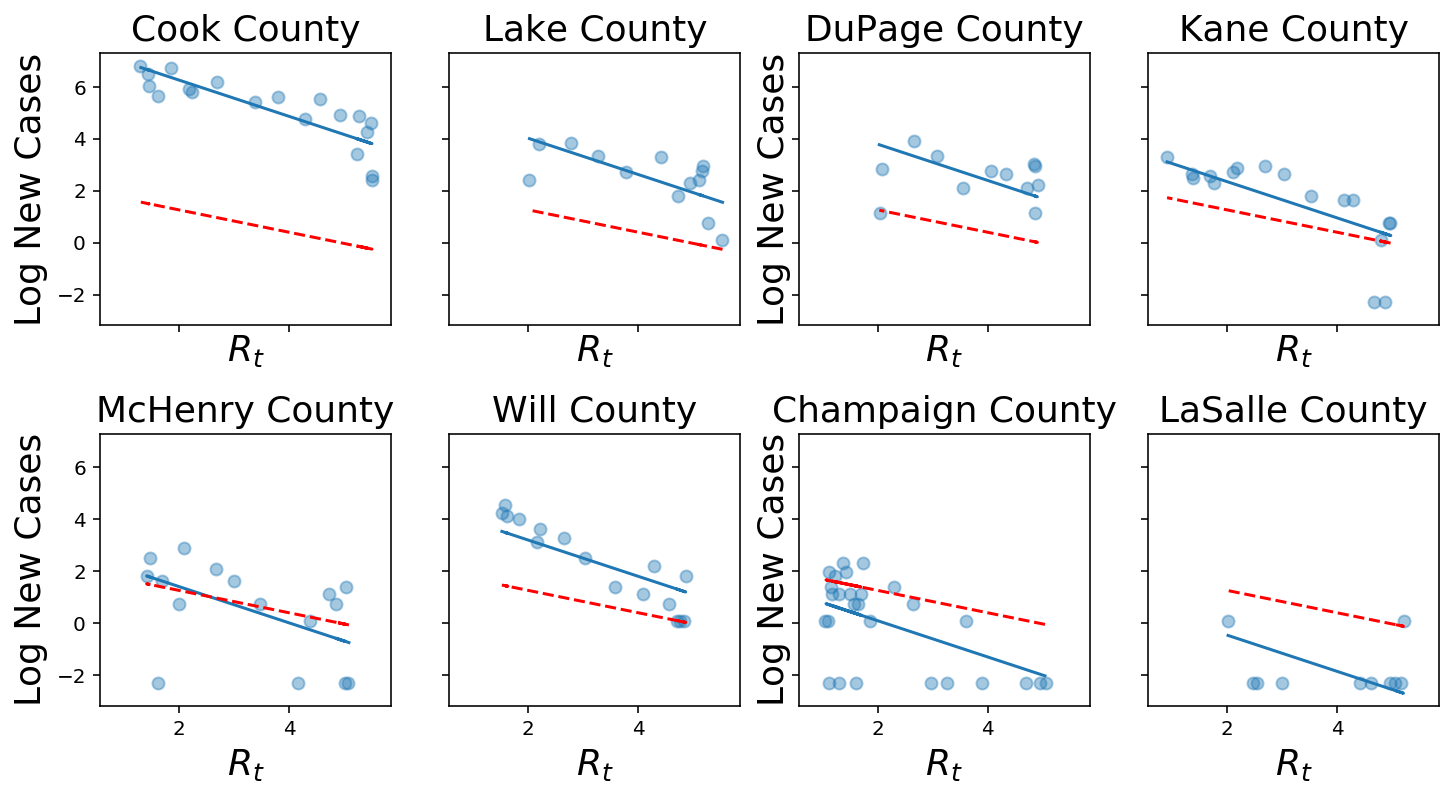

In [355]:
sample_counties =  state_data.county.unique()[:8].tolist()
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace['beta1'].mean()
plt.subplots_adjust(hspace=0.4)
for i,c in enumerate(sample_counties):
    x = state_data.atypical_ili[state_data.county==c]
    y = state_data.log_cases[state_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    # No pooling model
    b = unpooled_estimates[c]

    # Plot both models and data
    axes[i].plot(x, m*x+b)
    axes[i].plot(x, m0*x+b0, 'r--')
    axes[i].set_title(c, fontsize=18)
    axes[i].set_xlabel(r"$R_t$",  fontsize=18)

    if not i%2:
        axes[i].set_ylabel("Log New Cases", fontsize=18)
    
figure.tight_layout(pad=3.0);    
plt.savefig("reports/kinsa_counties_" + state + "_unpooled_model_estimates.pdf", bbox_inches="tight")
plt.show()
plt.close()      

# Partial pooling model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, a, sigma_a, mu_a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1693.50draws/s]


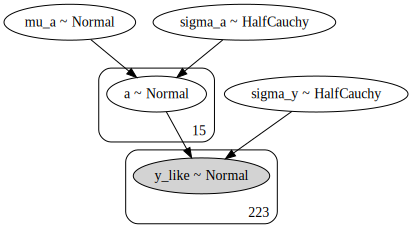

In [236]:
with Model() as partial_pooling:

    # Priors
    mu_a = Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = HalfCauchy('sigma_a', 5)

    # Random intercepts
    a = Normal('a', mu=mu_a, sigma=sigma_a, shape=counties)

    # Model error
    sigma_y = HalfCauchy('sigma_y',5)

    # Expected value
    y_hat = a[county]

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_case_values)
    partial_pooling_trace = sample(1000, tune=1000)

model_to_graphviz(partial_pooling)

## Varying intercept model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_y, b, a, sigma_a, mu_a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:06<00:00, 1243.84draws/s]
The number of effective samples is smaller than 25% for some parameters.


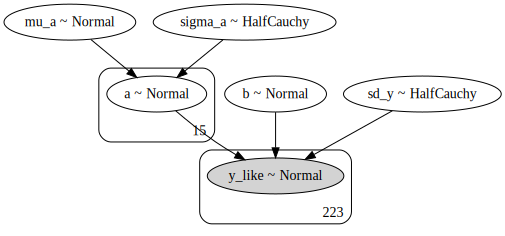

In [237]:
with Model() as varying_intercept:

    # Priors
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = HalfCauchy('sigma_a', 5)


    # Random intercepts
    a = Normal('a', mu=mu_a, sigma=sigma_a, shape=counties)
    # Common slope
    b = Normal('b', mu=0., sigma=1e5)

    # Model error
    sd_y = HalfCauchy('sd_y', 5)

    # Expected value
    y_hat = a[county] + b * atypical_ill_values

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sd_y, observed=log_case_values)
    
    varying_intercept_trace = sample(1000, tune=1000)

model_to_graphviz(varying_intercept)

<Figure size 432x1008 with 0 Axes>

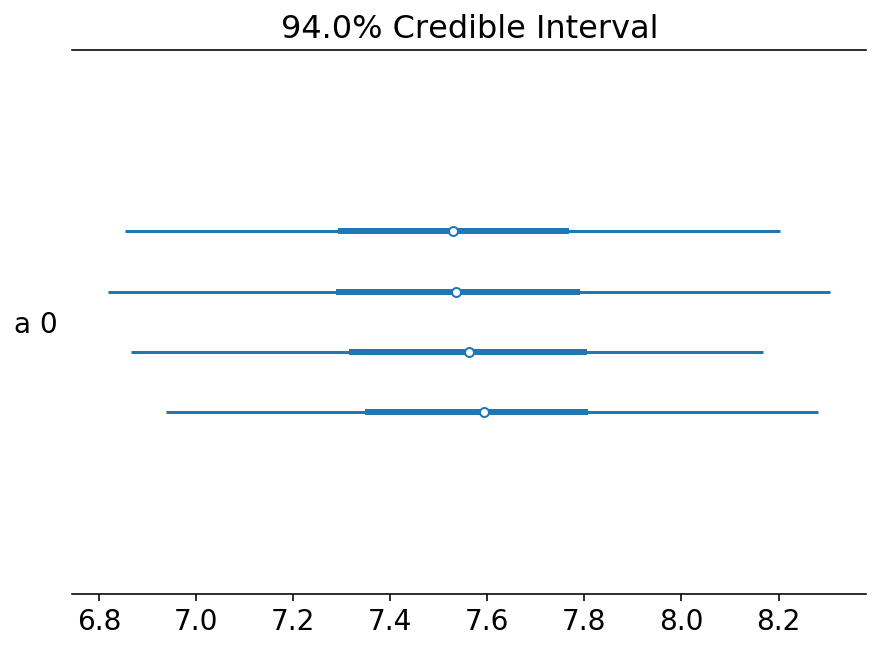

In [238]:
plt.figure(figsize=(6,14))
forestplot(varying_intercept_trace, var_names=['a'])
plt.show()
plt.close();

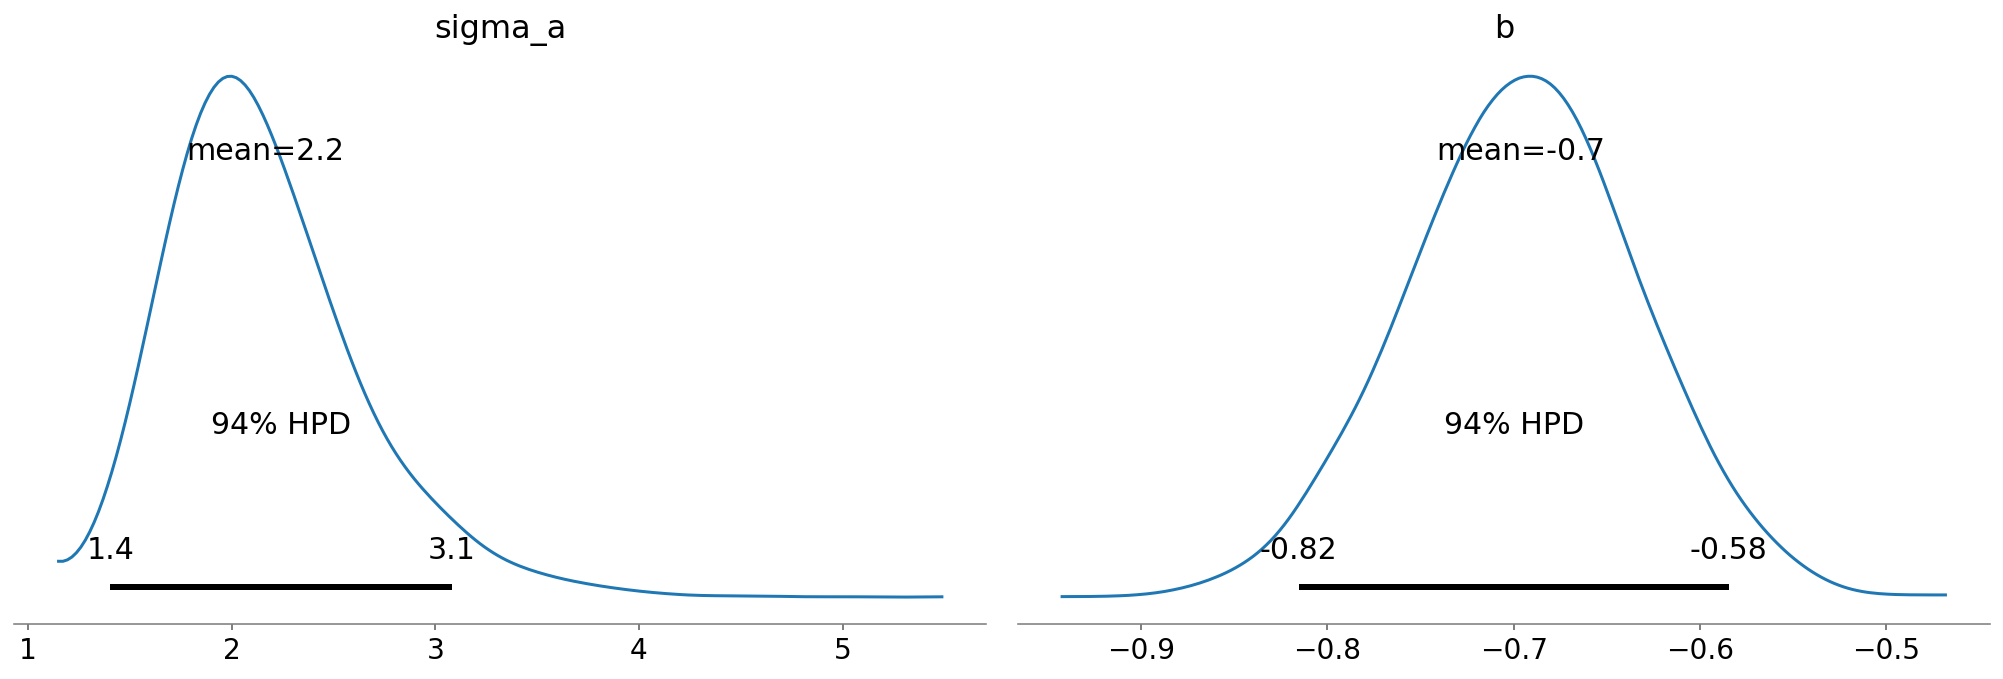

In [239]:
plot_posterior(varying_intercept_trace, var_names=['sigma_a', 'b']);

In [240]:
summary(varying_intercept_trace, varnames=['b'])

/Users/gryv9001/miniconda3/envs/dsai37/lib/python3.7/site-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b,-0.696,0.062,-0.815,-0.585,0.002,0.002,841.0,841.0,840.0,1523.0,1.0


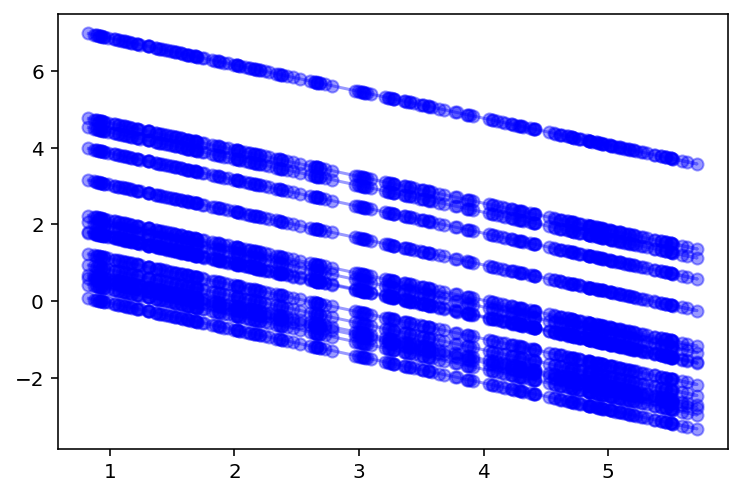

In [241]:
bp = varying_intercept_trace[a].mean(axis=0)
mp = varying_intercept_trace[b].mean()
for bi in bp:
    plt.plot(atypical_ill_values, mp*atypical_ill_values + bi, 'bo-', alpha=0.4)

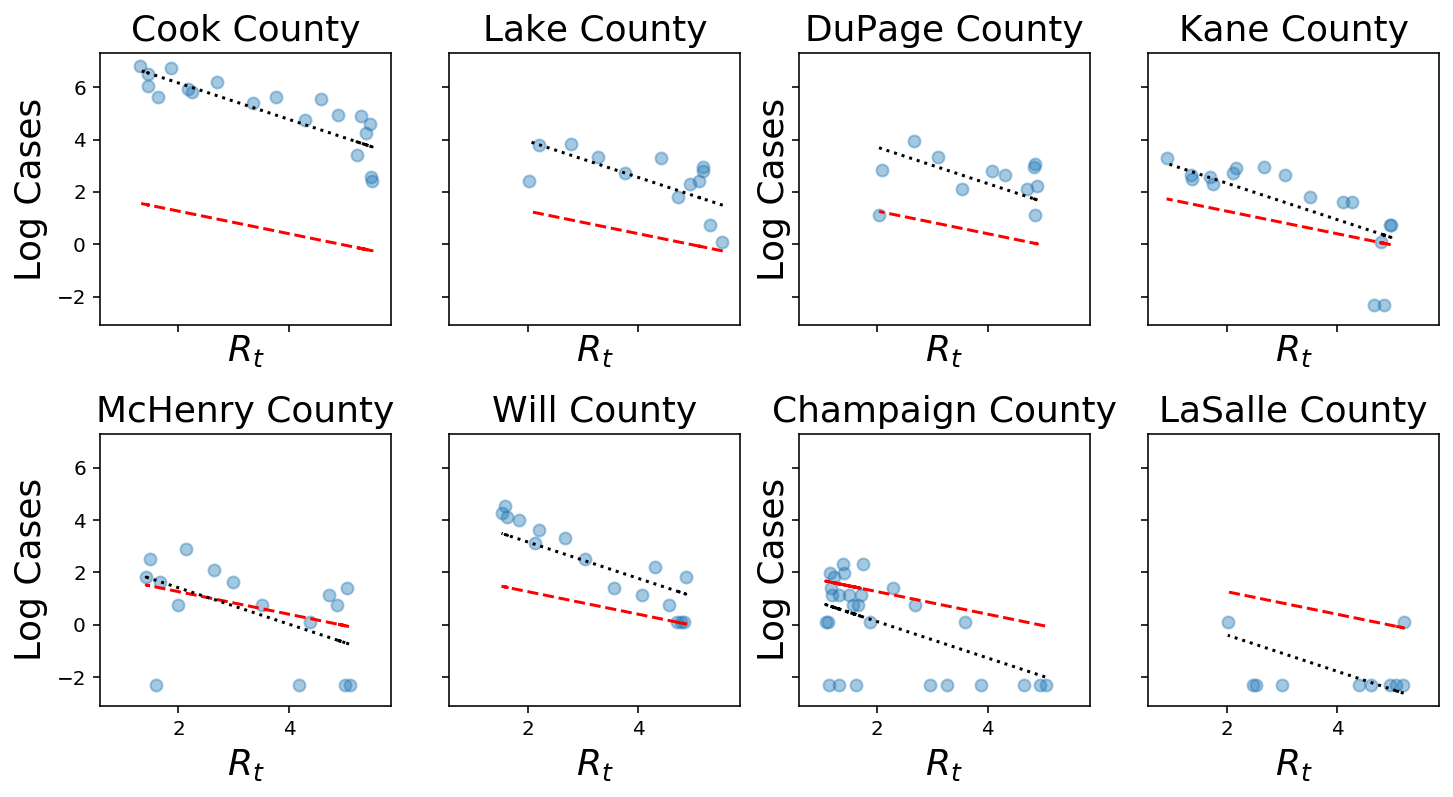

In [356]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)

axes = axes.ravel()
plt.subplots_adjust(hspace=0.4)

for i,c in enumerate(sample_counties):

    # Plot county data
    x = state_data.atypical_ili[state_data.county==c]
    y = state_data.log_cases[state_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    # No pooling model
    m,b = np.nan, unpooled_estimates[c]

    # Unpooled estimate
    axes[i].plot(x, m*x+b)
    # Pooled estimate
    axes[i].plot(x, m0*x+b0, 'r--')
    # Partial pooling esimate
    axes[i].plot(x, mp*x+bp[county_lookup[c]], 'k:')
    axes[i].set_title(c, fontsize=18)
    axes[i].set_xlabel(r"$R_t$",  fontsize=18)

    if not i%2:
        axes[i].set_ylabel("Log Cases", fontsize=18)

figure.tight_layout(pad=3.0);    
plt.savefig("reports/kinsa_counties_" + state + "_varying_intercept.pdf", bbox_inches="tight")
plt.show()
plt.close()             

## Varying slope model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b, a, sigma_b, mu_b]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1690.04draws/s]
The number of effective samples is smaller than 25% for some parameters.


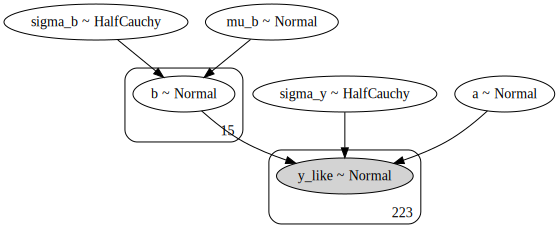

In [289]:
with Model() as varying_slope:

    # Priors
    mu_b = Normal('mu_b', mu=0., sigma=1e5)
    sigma_b = HalfCauchy('sigma_b', 5)

    # Common intercepts
    a = Normal('a', mu=0., sigma=1e5)
    # Random slopes
    b = Normal('b', mu=mu_b, sigma=sigma_b, shape=counties)

    # Model error
    sigma_y = HalfCauchy('sigma_y',5)

    # Expected value
    y_hat = a + b[county] * atypical_ill_values

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_case_values)
    varying_slope_trace = sample(1000, tune=1000)

model_to_graphviz(varying_slope)

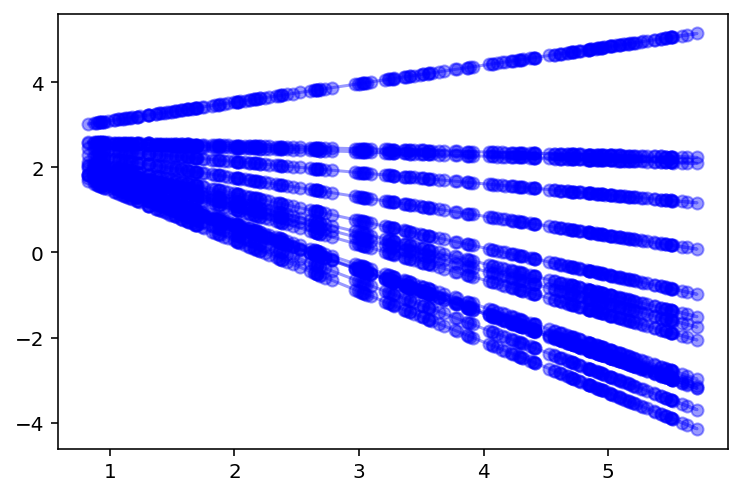

In [295]:
bv = varying_slope_trace['a'].mean(axis=0)
mv = varying_slope_trace['b'].mean(axis=0)
for mi in mv:
    plt.plot(atypical_ill_values, mi*atypical_ill_values + bv, 'bo-', alpha=0.4)

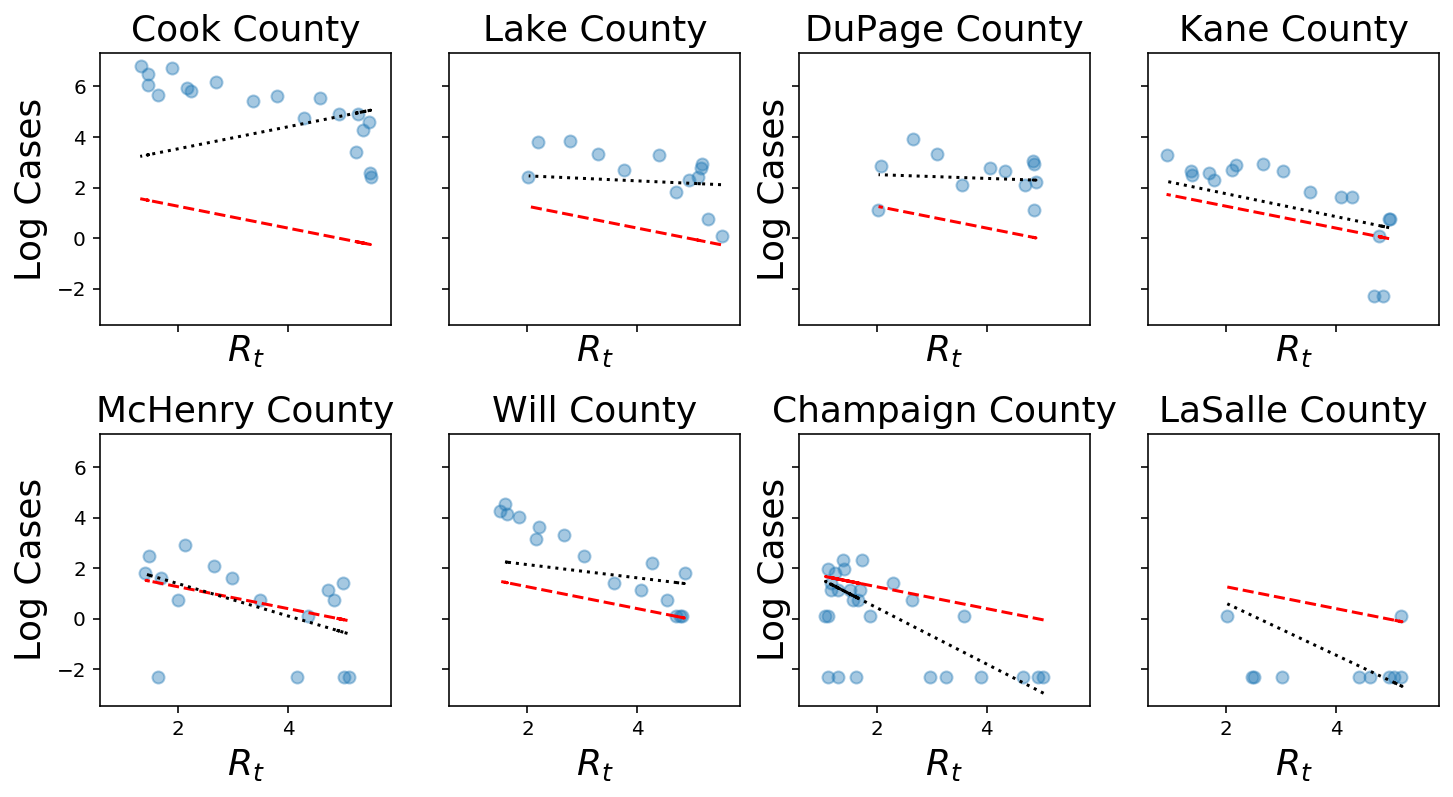

In [357]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)

axes = axes.ravel()
plt.subplots_adjust(hspace=0.4)
for i,c in enumerate(sample_counties):

    # Plot county data
    x = state_data.atypical_ili[state_data.county==c]
    y = state_data.log_cases[state_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    # No pooling model
    m,b = np.nan, unpooled_estimates[c]

    # Unpooled estimate
    axes[i].plot(x, m*x+b)
    # Pooled estimate
    axes[i].plot(x, m0*x+b0, 'r--')
    # Partial pooling estimate
    axes[i].plot(x, mv[county_lookup[c]]*x+bv, 'k:')
    axes[i].set_title(c, fontsize=18)
    axes[i].set_xlabel(r"$R_t$",  fontsize=18)

    if not i%2:
        axes[i].set_ylabel("Log Cases", fontsize=18)

figure.tight_layout(pad=3.0);    
plt.savefig("reports/kinsa_counties_" + state + "_varying_slope.pdf", bbox_inches="tight")
plt.show()
plt.close()             

## Varying intercept and slope model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains, 7 divergences: 100%|██████████| 8000/8000 [00:20<00:00, 390.26draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


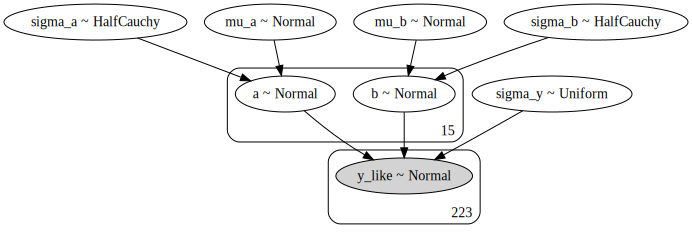

In [248]:
with Model() as varying_intercept_slope:

    # Priors
    mu_a = Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = HalfCauchy('sigma_a', 5)
    mu_b = Normal('mu_b', mu=0., sigma=1e5)
    sigma_b = HalfCauchy('sigma_b', 5)

    # Random intercepts
    a = Normal('a', mu=mu_a, sigma=sigma_a, shape=counties)
    # Random slopes
    b = Normal('b', mu=mu_b, sigma=sigma_b, shape=counties)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a[county] + b[county] * atypical_ill_values

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_case_values)
    varying_intercept_slope_trace = sample(1000, tune=1000)

model_to_graphviz(varying_intercept_slope)

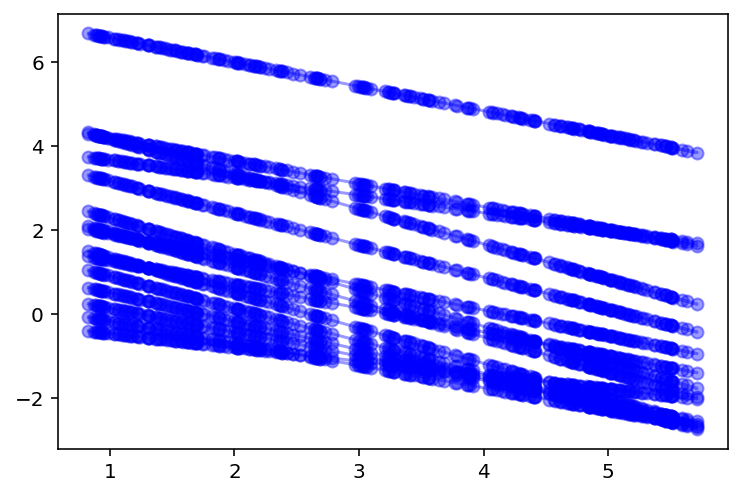

In [302]:
bvis = varying_intercept_slope_trace['a'].mean(axis=0)
mvis = varying_intercept_slope_trace['b'].mean(axis=0)
for bi,mi in zip(bvis,mvis):
    plt.plot(atypical_ill_values, mi*atypical_ill_values + bi, 'bo-', alpha=0.4)

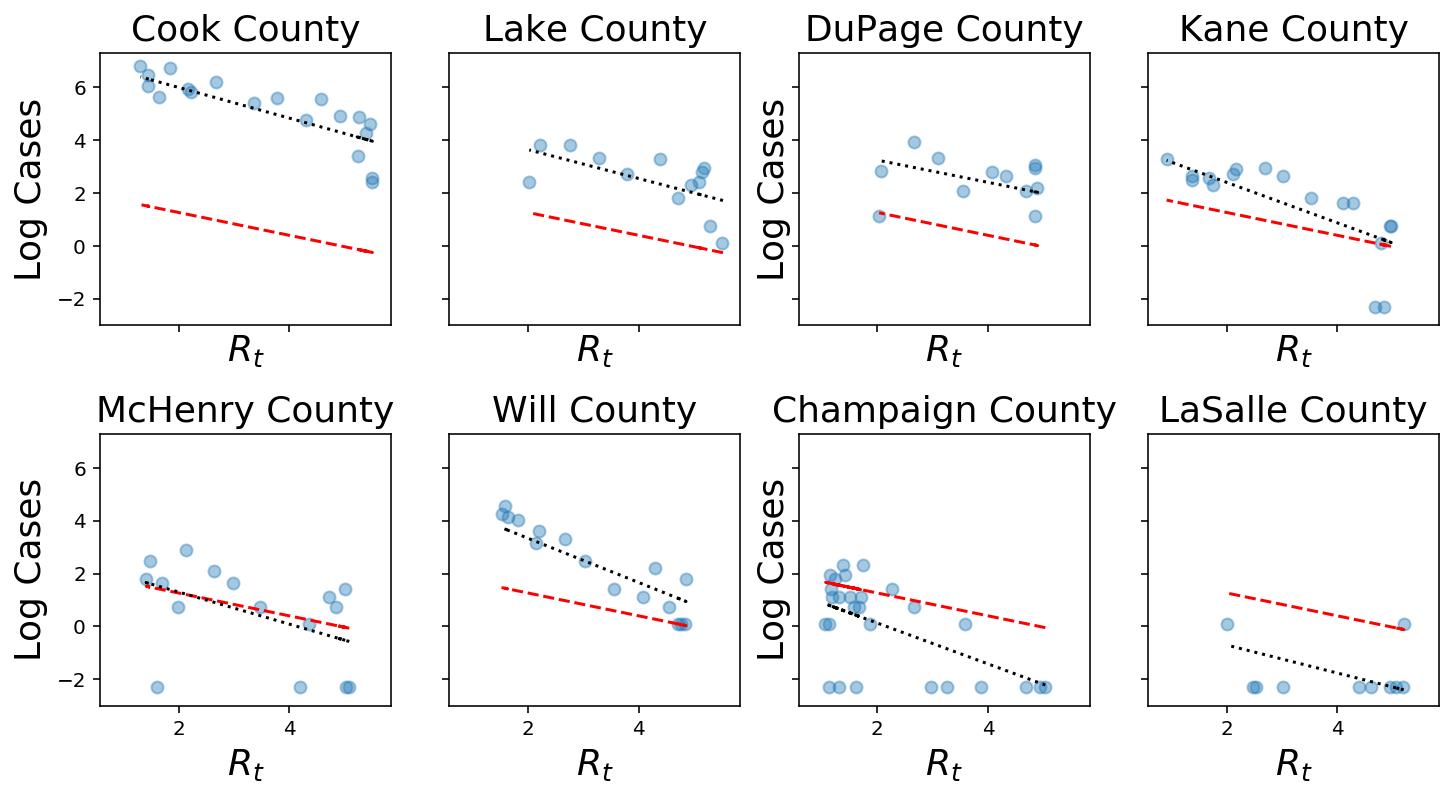

In [358]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)

axes = axes.ravel()
plt.subplots_adjust(hspace=0.4)

for i,c in enumerate(sample_counties):

    # Plot county data
    x = state_data.atypical_ili[state_data.county==c]
    y = state_data.log_cases[state_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    # No pooling model
    m,b = np.nan, unpooled_estimates[c]

    # Unpooled estimate
    axes[i].plot(x, m*x+b)
    # Pooled estimate
    axes[i].plot(x, m0*x+b0, 'r--')
    # Partial pooling esimate
    axes[i].plot(x, mvis[county_lookup[c]]*x+bvis[county_lookup[c]], 'k:')
    axes[i].set_title(c, fontsize=18)
    axes[i].set_xlabel(r"$R_t$",  fontsize=18)

    if not i%2:
        axes[i].set_ylabel("Log Cases", fontsize=18)

figure.tight_layout(pad=3.0);    
plt.savefig("reports/kinsa_counties_" + state + "_varying_intercept_slope.pdf", bbox_inches="tight")
plt.show()
plt.close()            

## Adding group-level predictors

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b, eps_a, gamma_1, gamma_0, sigma_a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:16<00:00, 493.31draws/s]
The acceptance probability does not match the target. It is 0.8818570704625183, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6617612747061945, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


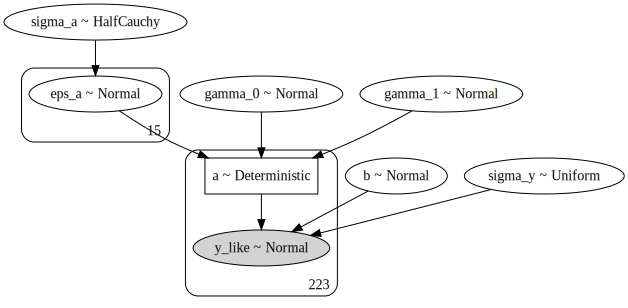

In [256]:
with Model() as hierarchical_intercept:

    # Priors
    sigma_a = HalfCauchy('sigma_a', 5)

    # County uranium model for slope
    gamma_0 = Normal('gamma_0', mu=0., sigma=1e5)
    gamma_1 = Normal('gamma_1', mu=0., sigma=1e5)


    # Transit model for intercept
    mu_a = gamma_0 + gamma_1*transit
    # County variation not explained by transit
    eps_a = Normal('eps_a', mu=0, sigma=sigma_a, shape=counties)
    a = pm.Deterministic('a', mu_a + eps_a[county])

    # Common slope
    b = Normal('b', mu=0., sigma=1e5)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a + b * atypical_ill_values

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_case_values)
    
    hierarchical_intercept_trace = sample(1000, tune=1000)

model_to_graphviz(hierarchical_intercept)

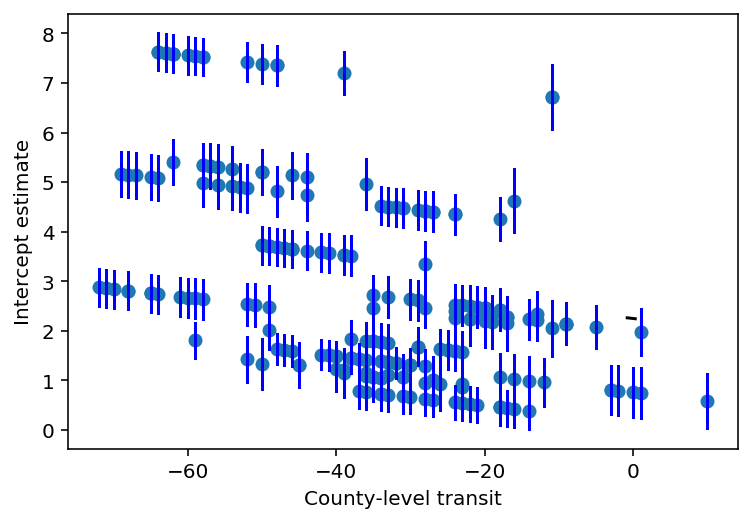

In [259]:
a_means = hierarchical_intercept_trace['a'].mean(axis=0)
plt.scatter(transit, a_means)
g0 = hierarchical_intercept_trace['gamma_0'].mean()
g1 = hierarchical_intercept_trace['gamma_1'].mean()
xvals = np.linspace(-1, 0.8)
plt.plot(xvals, g0+g1*xvals, 'k--')
#plt.xlim(-1, 0.8)

a_se = hierarchical_intercept_trace['a'].std(axis=0)
for ui, m, se in zip(transit, a_means, a_se):
    plt.plot([ui,ui], [m-se, m+se], 'b-')
plt.xlabel('County-level transit'); plt.ylabel('Intercept estimate');


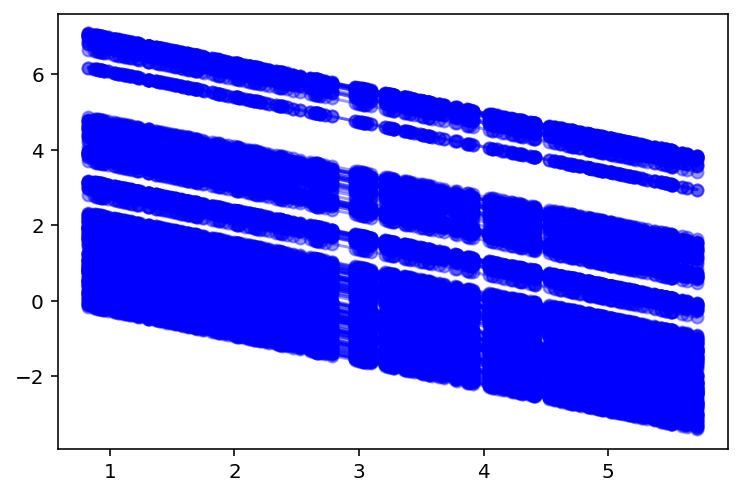

In [312]:
bhi = hierarchical_intercept_trace['a'].mean(axis=0)
mhi = hierarchical_intercept_trace['b'].mean(axis=0)
for b in bhi:
     plt.plot(atypical_ill_values, mhi*atypical_ill_values + b, 'bo-', alpha=0.4)

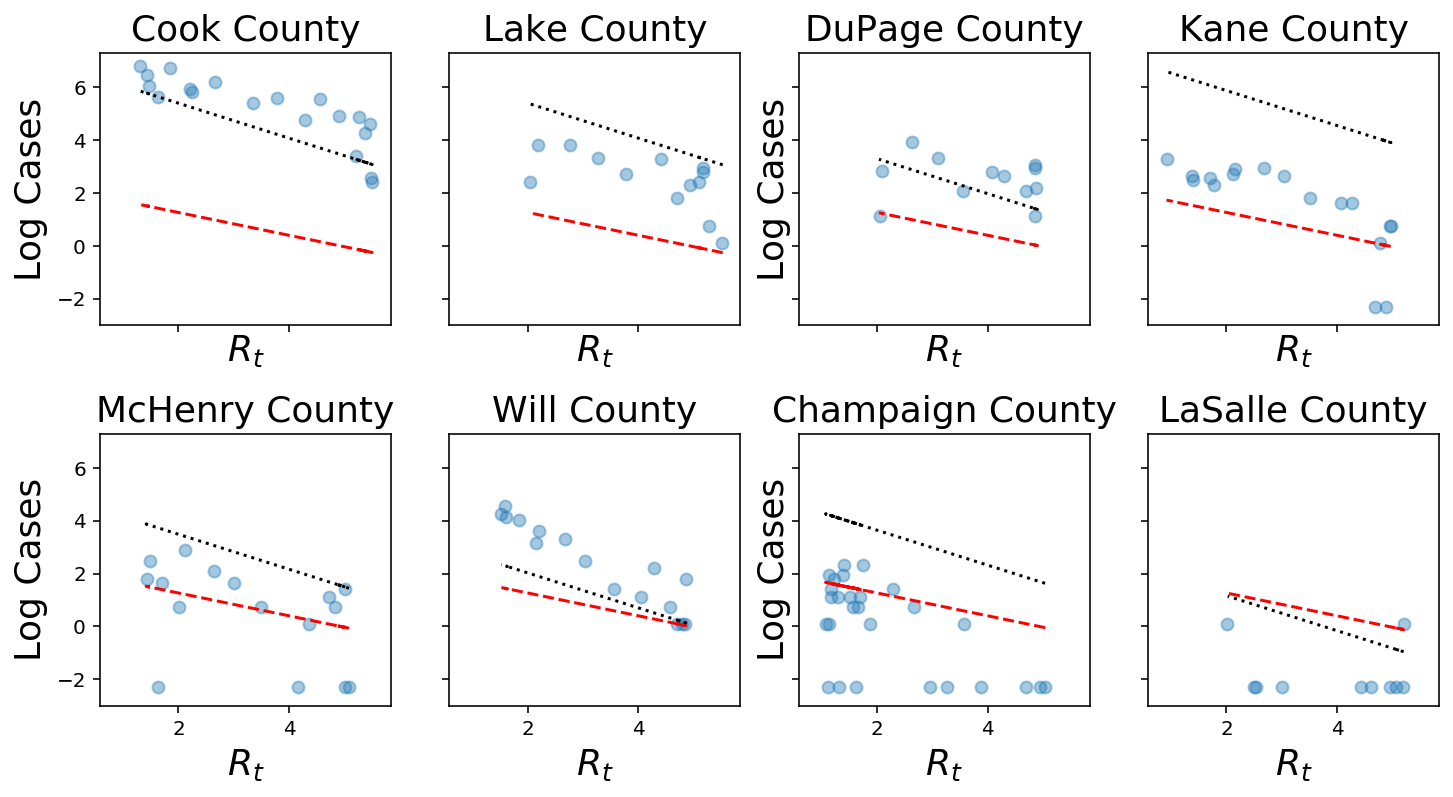

In [359]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)

axes = axes.ravel()
plt.subplots_adjust(hspace=0.4)

for i,c in enumerate(sample_counties):

    # Plot county data
    x = state_data.atypical_ili[state_data.county==c]
    y = state_data.log_cases[state_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    # No pooling model
    m,b = np.nan, unpooled_estimates[c]

    # Unpooled estimate
    axes[i].plot(x, m*x+b)
    # Pooled estimate
    axes[i].plot(x, m0*x+b0, 'r--')
    # Partial pooling esimate
    axes[i].plot(x, mhi*x+bhi[county_lookup[c]], 'k:')
    axes[i].set_title(c, fontsize=18)
    axes[i].set_xlabel(r"$R_t$",  fontsize=18)

    if not i%2:
        axes[i].set_ylabel("Log Cases", fontsize=18)

figure.tight_layout(pad=3.0);    
plt.savefig("reports/kinsa_counties_" + state + "_hierarchical_intercept.pdf", bbox_inches="tight")
plt.show()
plt.close()            

In [262]:
# Create new variable for mean of floor across counties
xbar = state_data.groupby('county')['atypical_ili'].mean().rename(county_lookup).values

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b, eps_a, gamma, sigma_a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [01:19<00:00, 101.15draws/s]
The number of effective samples is smaller than 25% for some parameters.


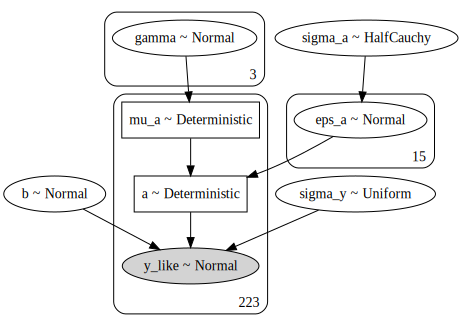

In [267]:
with Model() as contextual_effect:

    # Priors
    sigma_a = HalfCauchy('sigma_a', 5)

    # County transit model for slope
    gamma = Normal('gamma', mu=0., sigma=1e5, shape=3)

    # transit model for intercept
    mu_a = pm.Deterministic('mu_a', gamma[0] + gamma[1]*transit + gamma[2]*xbar[county])

    # County variation not explained by transit
    eps_a = Normal('eps_a', mu=0, sigma=sigma_a, shape=counties)
    a = pm.Deterministic('a', mu_a + eps_a[county])

    # Common slope
    b = Normal('b', mu=0., sigma=1e15)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a + b * atypical_ill_values

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_case_values)
    
    contextual_effect_trace = sample(1000, tune=1000)

model_to_graphviz(contextual_effect)

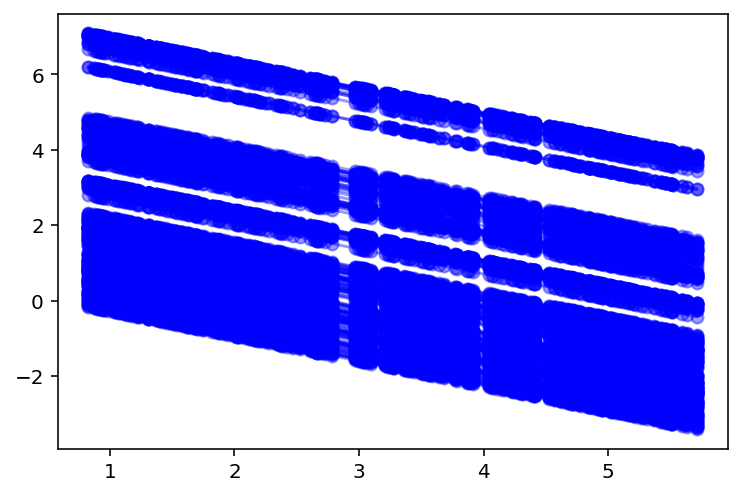

In [317]:
bc = contextual_effect_trace['a'].mean(axis=0)
mc = contextual_effect_trace['b'].mean(axis=0)
for b in bc:
    plt.plot(atypical_ill_values, mc*atypical_ill_values + b, 'bo-', alpha=0.4)

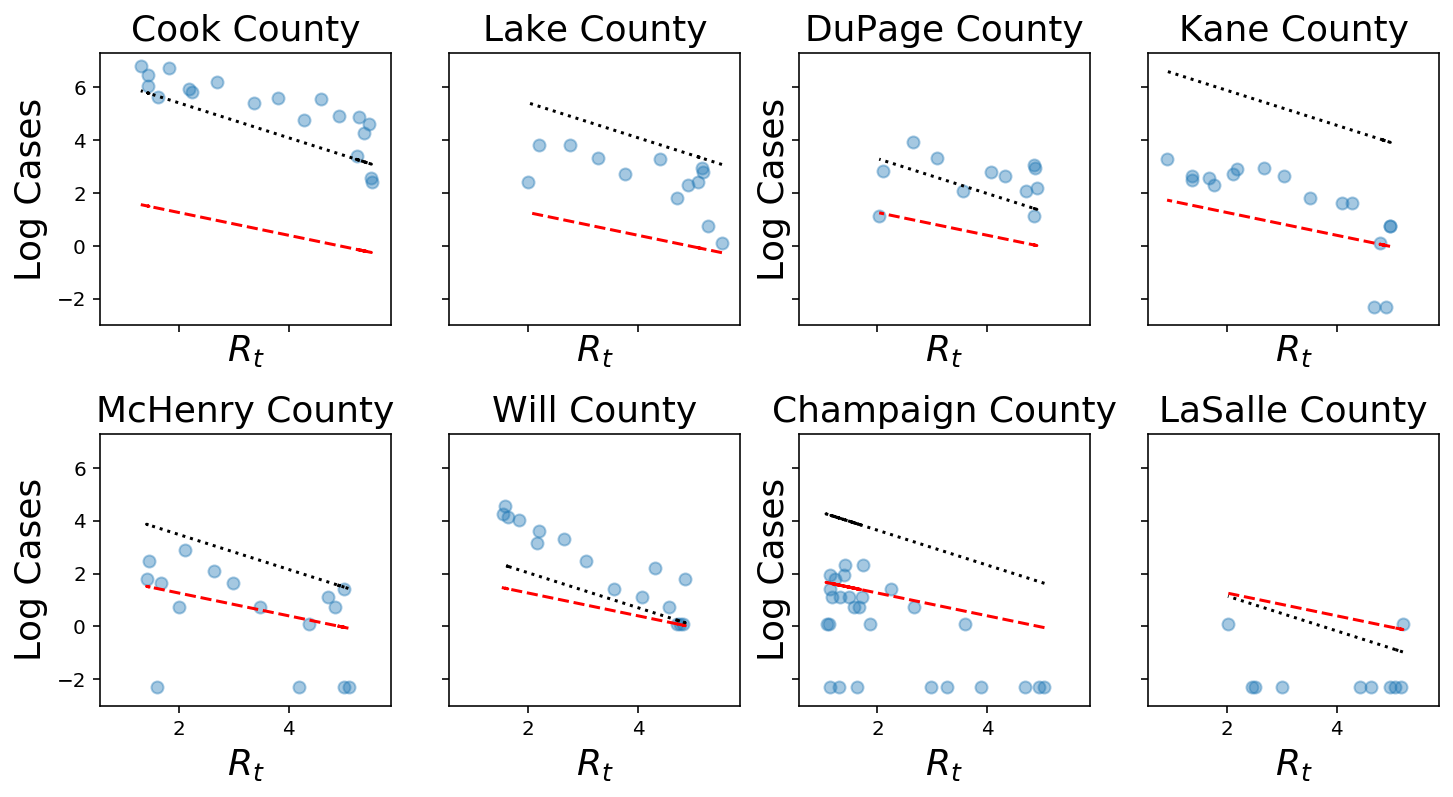

In [360]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)

axes = axes.ravel()
plt.subplots_adjust(hspace=0.4)

for i,c in enumerate(sample_counties):

    # Plot county data
    x = state_data.atypical_ili[state_data.county==c]
    y = state_data.log_cases[state_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    # No pooling model
    m,b = np.nan, unpooled_estimates[c]

    # Unpooled estimate
    axes[i].plot(x, m*x+b)
    # Pooled estimate
    axes[i].plot(x, m0*x+b0, 'r--')
    # Partial pooling esimate
    axes[i].plot(x, mc*x+bc[county_lookup[c]], 'k:')
    axes[i].set_title(c, fontsize=18)
    axes[i].set_xlabel(r"$R_t$",  fontsize=18)

    if not i%2:
        axes[i].set_ylabel("Log Cases", fontsize=18)

figure.tight_layout(pad=3.0);    
plt.savefig("reports/kinsa_counties_" + state + "_contextual.pdf", bbox_inches="tight")
plt.show()
plt.close()            

In [268]:
summary(contextual_effect_trace, varnames=['gamma'])

/Users/gryv9001/miniconda3/envs/dsai37/lib/python3.7/site-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
gamma[0],3.344,2.977,-2.146,9.078,0.098,0.069,918.0,918.0,900.0,1292.0,1.0
gamma[1],-0.017,0.011,-0.036,0.003,0.000,0.000,1790.0,1790.0,1785.0,2177.0,1.0
gamma[2],-0.328,0.867,-1.972,1.276,0.028,0.020,942.0,942.0,927.0,1167.0,1.0


## Predictions

In [272]:
county_name = "McLean County"
county_lookup[county_name]

10

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pred, sigma_y, b, eps_a, gamma, sigma_a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [01:22<00:00, 96.59draws/s] 
The number of effective samples is smaller than 25% for some parameters.


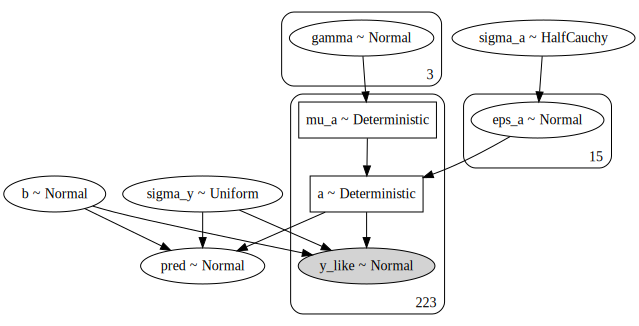

In [273]:
with Model() as contextual_pred:

    # Priors
    sigma_a = HalfCauchy('sigma_a', 5)

    # County transit model for slope
    gamma = Normal('gamma', mu=0., sigma=1e5, shape=3)

    # Transit model for intercept
    mu_a = pm.Deterministic('mu_a', gamma[0] + gamma[1]* transit + gamma[2]*xbar[county])

    # County variation not explained by transit
    eps_a = Normal('eps_a', mu=0, sigma=sigma_a, shape=counties)
    a = pm.Deterministic('a', mu_a + eps_a[county])

    # Common slope
    b = Normal('b', mu=0., sigma=1e15)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a + b * atypical_ill_values

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_case_values)

    # County prediction
    pred = Normal('pred', mu=a[10] + b, sigma=sigma_y)
    
    contextual_pred_trace = sample(1000, tune=1000)

model_to_graphviz(contextual_pred)

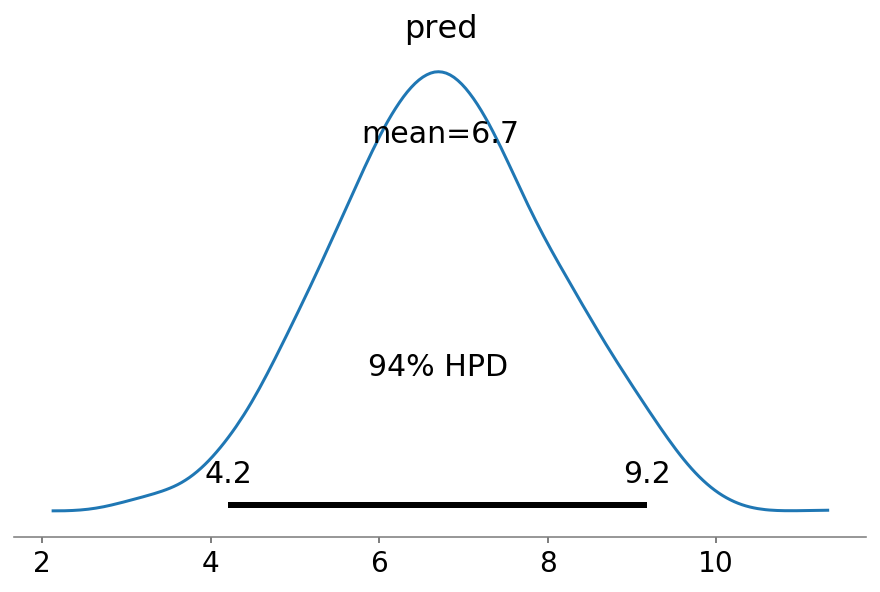

In [276]:
dist= plot_posterior(contextual_pred_trace, var_names=["pred"])

In [283]:
print(np.exp([4.2, 6.7, 9.2]))

[  66.68633104  812.40582517 9897.12905874]


In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)

axes = axes.ravel()
for i,c in enumerate(sample_counties):

    # Plot county data
    x = state_data.atypical_ili[state_data.county==c]
    y = state_data.log_cases[state_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    # No pooling model
    m,b = np.nan, unpooled_estimates[c]

    # Unpooled estimate
    axes[i].plot(x, m*x+b)
    # Pooled estimate
    axes[i].plot(x, m0*x+b0, 'r--')
    # Partial pooling esimate
    axes[i].plot(x, mp*x+bp[county_lookup[c]], 'k:')
    axes[i].set_title(c, fontsize=18)
    if not i%2:
        axes[i].set_ylabel("Log Cases", fontsize=18)

figure.tight_layout(pad=3.0);    
plt.savefig("reports/kinsa_counties_" + state + "_varying_intercept.pdf", bbox_inches="tight")
plt.show()
plt.close()             